In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import random

In [2]:
#Define Functions
def GetAllSamples(sample_df, sample_list, region):
    #Define local variables
    sum_df = pd.DataFrame()
    selectCpGs = pd.DataFrame()
    first = True

    for sample in sample_list:
        test = sample_df[["CHR", "Location", sample]]
        selectCpGs = test[(test["CHR"] == region["chr"]) & (test["Location"] >= region["Start"]) & (test["Location"] <= region["Stop"])]
        if first == True:
            sum_df = selectCpGs
            first = False
        else:
            sum_df = pd.concat([sum_df, selectCpGs[sample]], axis=1) #adds one sample column to df
            
    #time to summarize data
    plain_df = sum_df.iloc[:,2:] # trim to cpg info to calculate means 
    final_df = pd.concat([plain_df.mean(axis=1, skipna=True),sum_df], axis=1) #adds mean column to df
    final_df = final_df.rename(columns= {0: "Mean"})
    final_df = pd.concat([plain_df.std(axis=1, skipna=True),final_df], axis=1) #adds std column to df
    final_df = final_df.rename(columns= {0 : "Standard_Dev"})
    return final_df

#Find Colors 
def Attach_Colors(class_val):
    if class_val == "Normal":
        return "yellow"
    if class_val == "Pattern 3":
        #return "yellow"
        return "orange"
    if class_val == "Pattern 4":
        #return "red"
        return "blue"
    if class_val == "Pattern 5":
        return "purple"
    if class_val == "Pattern 6":
        return "purple"
    if class_val == "Pattern 7":
        return "brown"
    if class_val == "Pattern 8":
        return "black"
        
#Create Subset with List
def Make_Subset(main_df, subset_list):
    subset_df = pd.DataFrame()
    for item in main_df.index:
        if item in subset_list:
            subset_df = pd.concat([subset_df,main_df.loc[item,:]], axis = 1)
    return (subset_df).T

#Create Anti-Subset with List
def Make_Anti_Subset(main_df, subset_list):
    subset_df = pd.DataFrame()
    for item in main_df.index:
        if item not in subset_list:
            subset_df = pd.concat([subset_df,main_df.loc[item,:]], axis = 1)
    return (subset_df).T



def get_region_means(regions, df):
  chrset = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10","chr11","chr12","chr13", "chr14", "chr15", "chr16", "chr17","chr18", "chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]
  results_mean = pd.DataFrame()

  #Main Region Function
  first = True
  for chr in chrset:
    chr_regions = pd.DataFrame()
    df_regions = pd.DataFrame()
    chr_regions = regions[regions["CHR"] == chr]
    df_regions = df[df["CHR"] == chr]
    #print(df_regions)
    
    for index in chr_regions.index:
      #create temp array for holding start and stop values of a region
      ## Decide here if you want NEW (trimmed) or OLD regions
      Start = chr_regions.loc[index, "Start"]
      Stop = chr_regions.loc[index, "Stop"]
      #select for only CpG's within the given region
      r = df_regions[(df_regions["Location"] >= Start) & (df_regions["Location"] <= Stop)]
      r = r.drop(["CHR", "Location"], axis = 1)
      ### r = r.drop(["CHR", "Location", "CHR.1", "Location.1"], axis = 1)
      #track the number of CpG's in given region
      l = len((r.index))
      r = r.apply(np.nanmean) #remove na's ??
      #calculate the mean of the row, rewrite itself
      anno_series = pd.Series(dtype=object)
      anno_series["Name"] = f"{chr}:{int(Start)}-{int(Stop)}"
      anno_series["CHR"] = chr
      anno_series["Start"] = Start
      anno_series["Stop"] = Stop
      anno_series["CPG_Count"] = l
      r = pd.concat([anno_series,r])
      r = (r.to_frame()).T 
      if first == True:
        results_mean= r
        first = False
      else:
        results_mean = pd.concat([results_mean,r], axis=0)

  results_mean.index = results_mean["Name"]
  results_mean = results_mean.drop(["Name"],axis=1)
  results_mean = results_mean.rename_axis(None, axis=0) #remove index title

  #Let's remove all the extra info
  clean_results_mean = results_mean.iloc[:,4:]
  return clean_results_mean

In [4]:
### Explanation of purpose
# 1. Load all FAZST data and regions of interest
# 2. Identify training and testing samples (probably 2/3 for training, 1/3 for testing)
# 3. Generate mean of all cpgs in each region for each sample
# 4. Using each region as a feature, train a model to predict cancer stage

In [3]:
master_sample_list = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/samplekeys.csv")

In [4]:
#Let's get region means
blood_results_mean = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/binary_dataframes/blood_binary.csv", index_col=0)
fazst_results_mean = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/binary_dataframes/fazst_binary.csv", index_col=0)
cont = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/binary_dataframes/cont_binary.csv", index_col=0)

#Drop any rows that are totally empty/na in either dataset
blood_results_mean = blood_results_mean.dropna(axis=0, how="all")
fazst_results_mean = fazst_results_mean.dropna(axis=0, how="all")

#Drop any columns that are totally empty/na in either dataset
blood_results_mean = blood_results_mean.dropna(axis=1, how="all")
fazst_results_mean = fazst_results_mean.dropna(axis=1, how="all")

#Drop any rows that include Na's in the fazst dataset
blood_results_mean = blood_results_mean.dropna(axis=0, how="any")
fazst_results_mean = fazst_results_mean.dropna(axis=0, how="any")

#Drop any index that is not in both datasets
blood_results_mean = blood_results_mean.loc[blood_results_mean.index.isin(fazst_results_mean.index)]
fazst_results_mean = fazst_results_mean.loc[fazst_results_mean.index.isin(blood_results_mean.index)]



In [5]:
#Lets load in somatic cells
somatic_cells = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/binary_dataframes/somatic_binary.csv", index_col=0)

#Select for the samples that are in the "urothelial" and "prostate" groups in the master sample list
samples = master_sample_list["uro"].dropna().tolist()[:20]

samples += master_sample_list["prostate"].dropna().tolist()[:20]

#edit the columns to only include the string before the first "_"
somatic_cells.columns = [x.split("_")[0] for x in somatic_cells.columns]

#Drop any rows that are Nan
somatic_cells = somatic_cells.dropna(axis=0, how="all")

#Only include samples in the samples list
somatic_cells = somatic_cells[samples]

# somatic_cells.to_csv("/Users/carternorton/Desktop/SomaticLike/uro_pro_region_means.csv")


/Users/carternorton/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2880x2880 with 0 Axes>

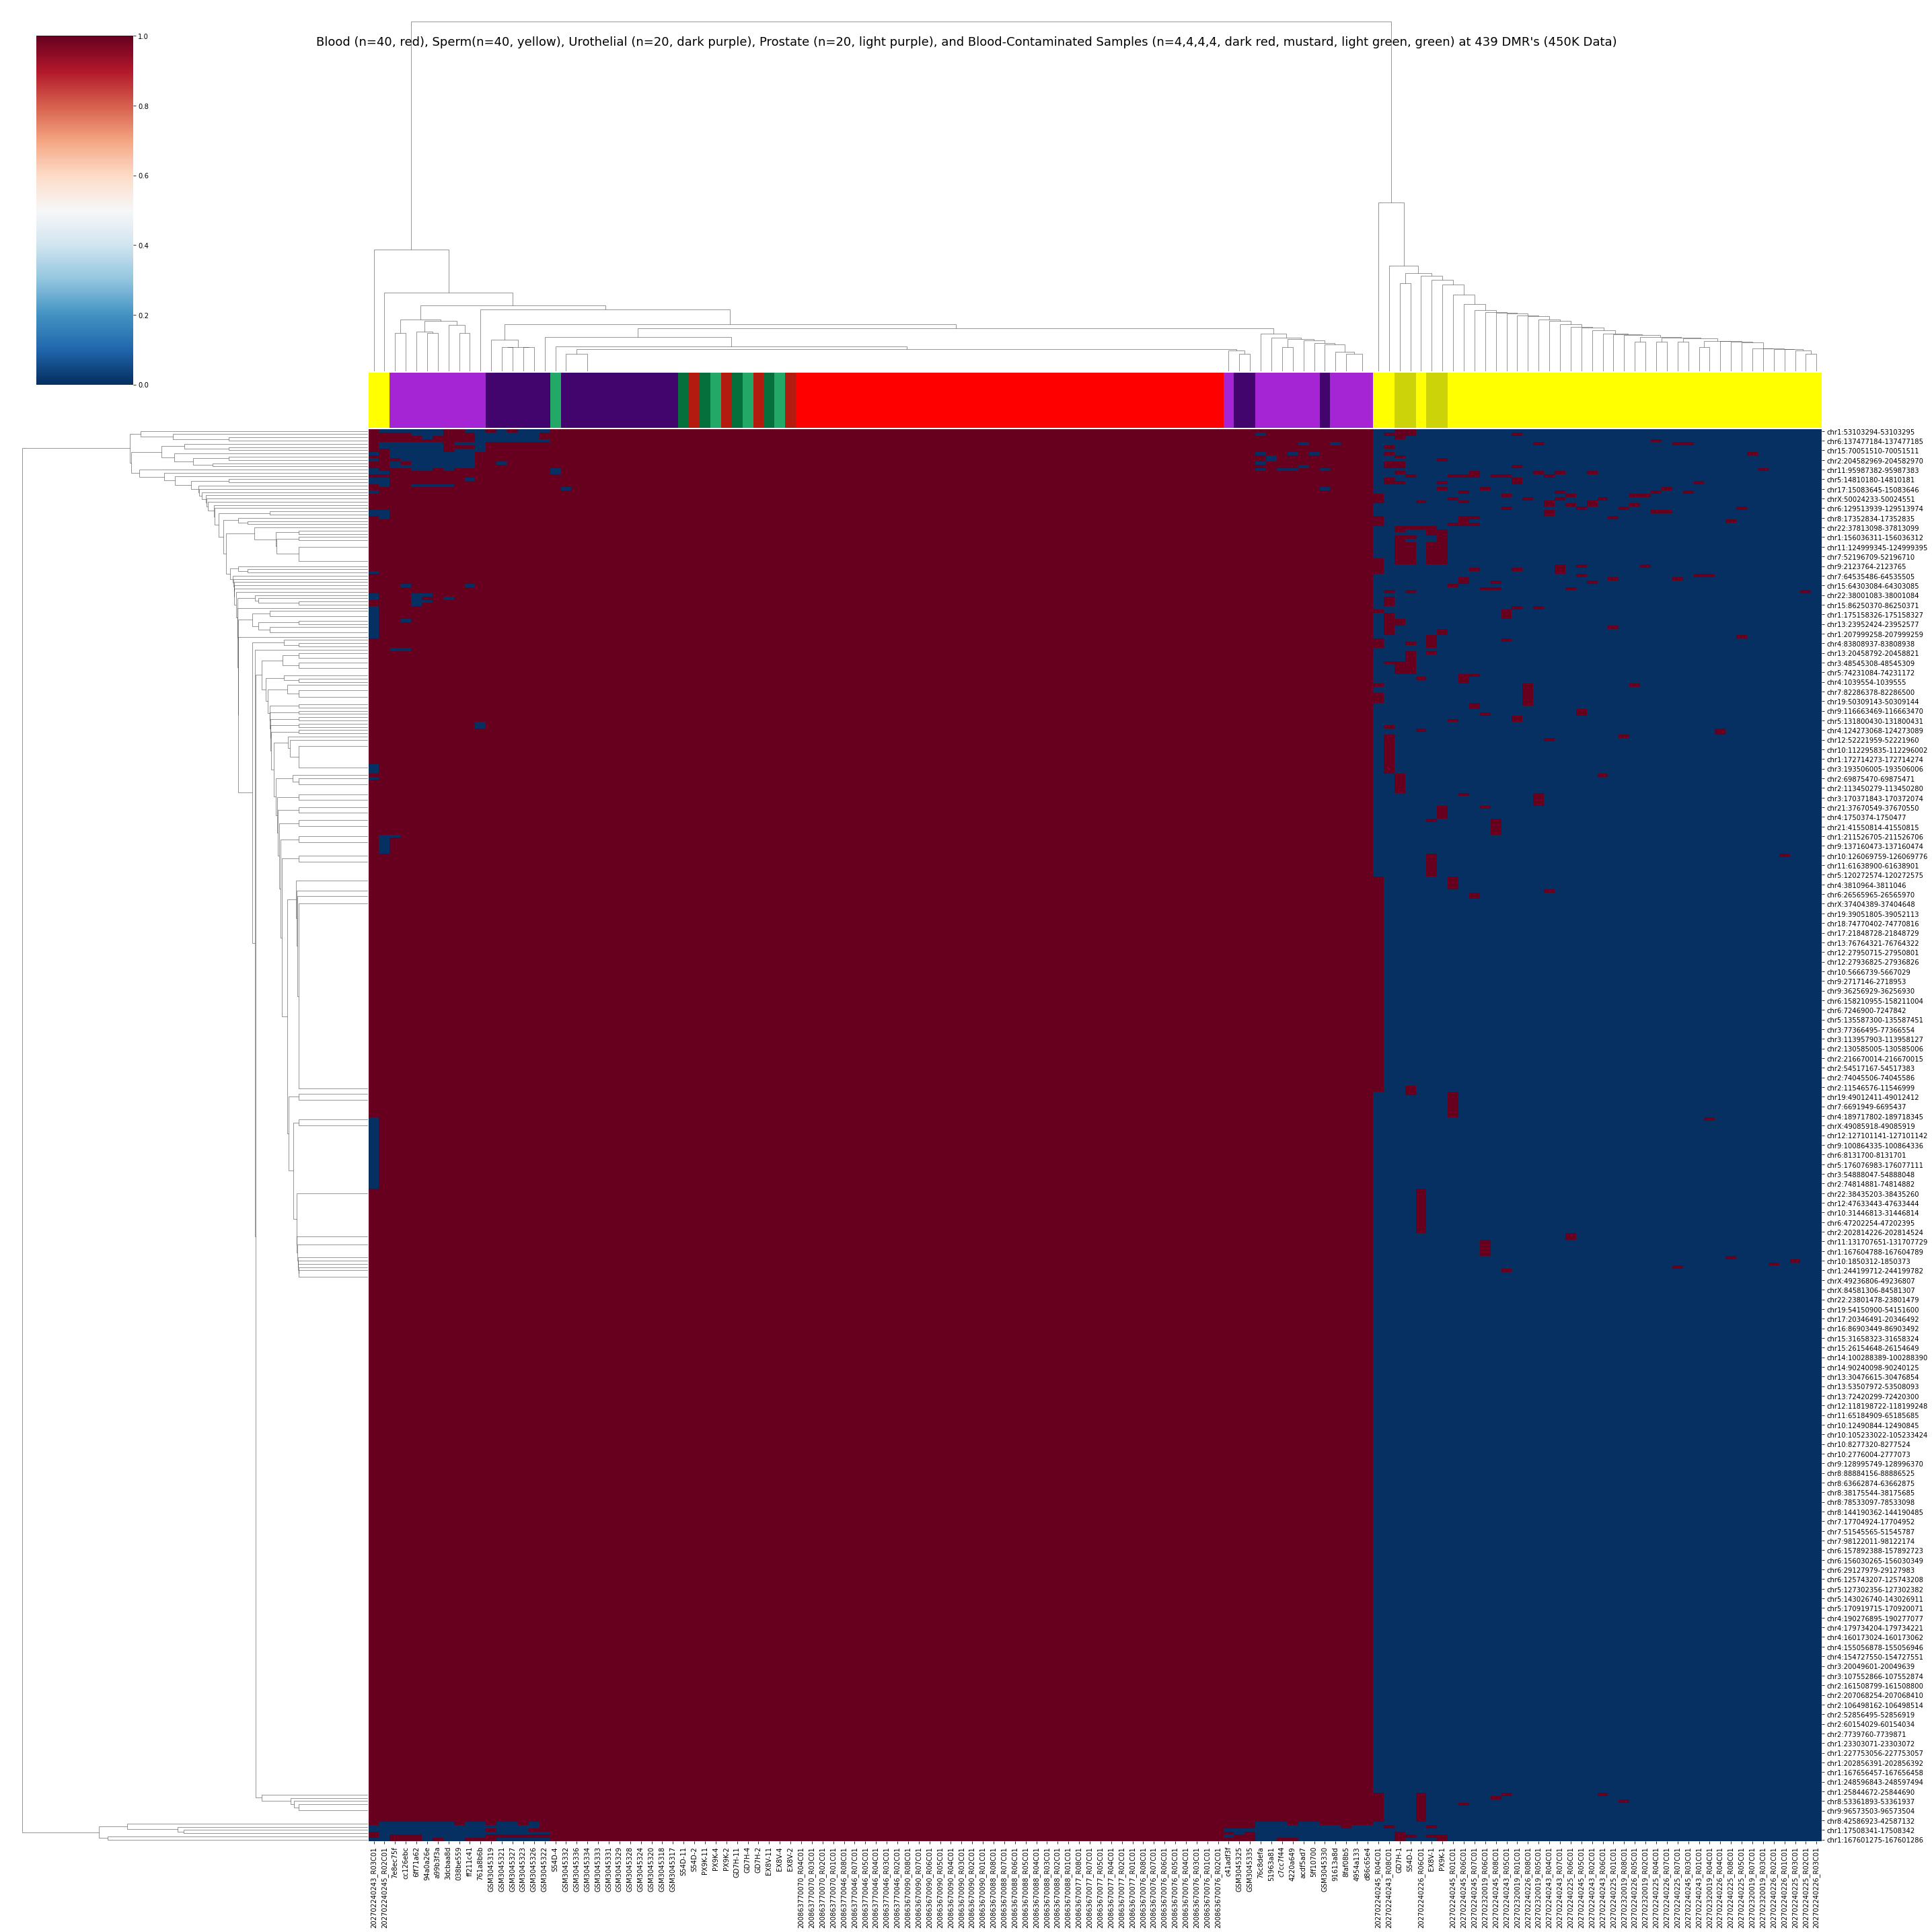

In [8]:
#Let's make a heatmap and get a general idea of what we're looking at
#Make a list of samples types, it will have "green" for every column in blood_results_mean, and "red" for every column in fazst_results_mean

#Let's limit each df to only 50 samples
blood_results_mean2 = blood_results_mean.iloc[:,0:40]
fazst_results_mean2 = fazst_results_mean.iloc[:,0:40]

#Now let's make a list of colors for clustermap
sample_type_list = []
for i in range(len(blood_results_mean2.columns)):
    sample_type_list.append("red")
for i in range(len(fazst_results_mean2.columns)):
    sample_type_list.append("yellow")
for i in range(len(cont.columns)):
    if(cont.columns[i].endswith("-1")):
        sample_type_list.append("#CDD309") #mustard
    elif(cont.columns[i].endswith("-2")):
        sample_type_list.append("#b31b10") #orange
    elif(cont.columns[i].endswith("-4")):
        sample_type_list.append("#23a868") #light green
    elif(cont.columns[i].endswith("-11")):
        sample_type_list.append("#06703d") #dark green
for i in range(len(somatic_cells.columns)):
    if(somatic_cells.columns[i].startswith("GSM")):
        sample_type_list.append("#42056e") #dark purple
    else:
        sample_type_list.append("#a524d4") #purple


#Let's limit all dataframes to the indexes including in cont
blood_results_mean2 = blood_results_mean2.loc[blood_results_mean.index.isin(cont.index)]
fazst_results_mean2 = fazst_results_mean2.loc[fazst_results_mean.index.isin(cont.index)]
somatic_cells2 = somatic_cells.loc[somatic_cells.index.isin(cont.index)]

#now combine all three dataframes
combined_df = pd.concat([blood_results_mean2, fazst_results_mean2, cont, somatic_cells], axis=1)

#Drop any rows that include na's
combined_df = combined_df.dropna(axis=0, how="any")

#Make a heatmap
plt.figure(figsize=(40,40))
clustermap = sb.clustermap(combined_df, cmap="RdBu_r", col_colors=sample_type_list, figsize=(40,40))
clustermap.fig.suptitle("Blood (n=40, red), Sperm(n=40, yellow), Urothelial (n=20, dark purple), Prostate (n=20, light purple), and Blood-Contaminated Samples (n=4,4,4,4, dark red, mustard, light green, green) at 439 DMR's (450K Data)", fontsize=18)
# clustermap.fig.suptitle("Blood (n=40, red), Sperm(n=40, yellow), and Blood-Contaminated Samples (n=4,4,4,4, dark red, mustard, light green, green) at 436 DMR's (450K Data)", fontsize=18)

#Save heatmep
plt.savefig("/Users/carternorton/Desktop/SomaticLike/heatmaps/450Regions_blood_sperm_contaminate_somatic_BINARY.png")

plt.show()



In [6]:
#We need to access the FAZST data and find a list of oligospermic samples
fazst_meta = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/FAZST_RAW_RESULTS_CLINICAL_DATA_5_28_22.csv", index_col=0)

#Make a list of "Sentrix_Info" that are "1" in the "low_count" column
oligo_samples = fazst_meta.loc[fazst_meta["low_count"] == 1]["Sentrix_Info"].tolist()
non_oligo_samples = fazst_meta.loc[fazst_meta["low_count"] == 0]["Sentrix_Info"].tolist()

#Drop any samples for either list that are not found in the fazst_means columns
oligo_samples = [x for x in oligo_samples if x in fazst_results_mean.columns]
non_oligo_samples = [x for x in non_oligo_samples if x in fazst_results_mean.columns]

print(len(oligo_samples))
len(non_oligo_samples)


94


1288

In [7]:
#Make a list of all samples that pass DLK1
dlk1_samples = fazst_meta.loc[fazst_meta["DLK1_Mean"] >= .2]["Sentrix_Info"].tolist()
non_dlk1_samples = fazst_meta.loc[fazst_meta["DLK1_Mean"] < .15]["Sentrix_Info"].tolist()

print(len(dlk1_samples))
len(non_dlk1_samples)

115


960

In [8]:
#Drop oligo samples that are included in dlk1
oligo_samples = [x for x in oligo_samples if x not in dlk1_samples]
non_oligo_samples = [x for x in non_oligo_samples if x not in dlk1_samples]

print(len(oligo_samples))
len(non_oligo_samples)

78


1189

/Users/carternorton/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


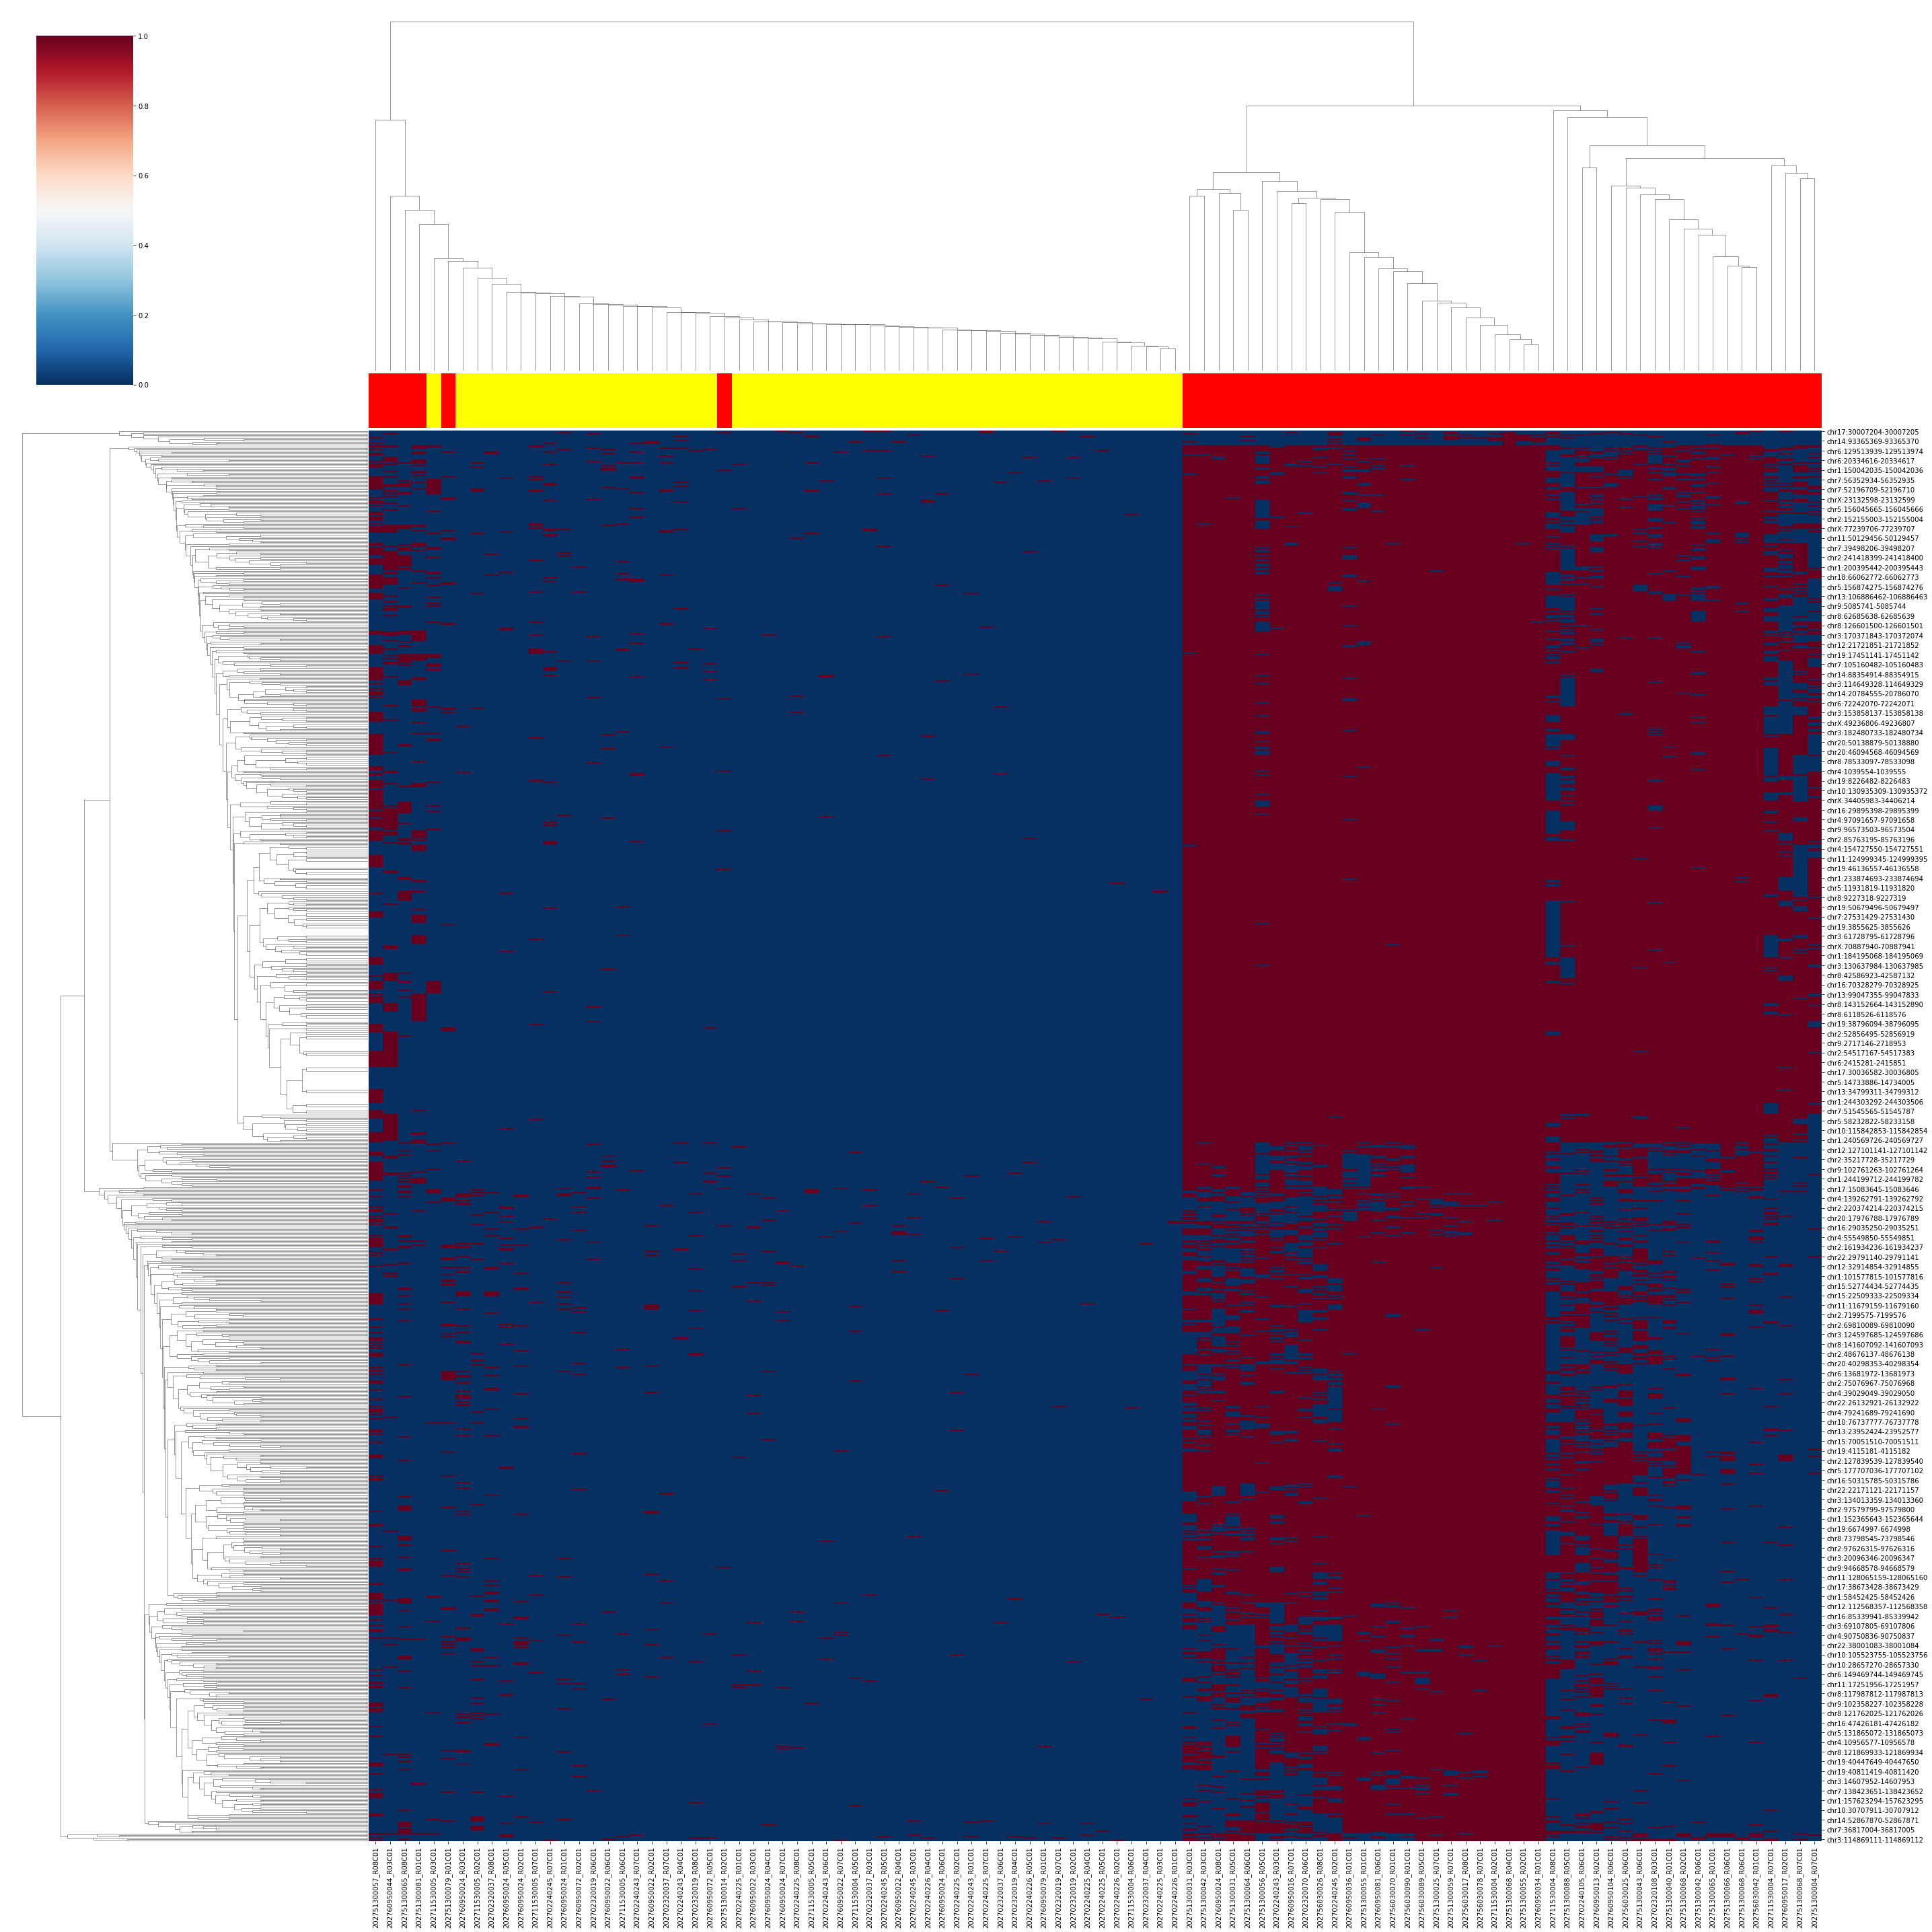

In [9]:
#First, let's make a heatmap of 50 samples that pass dlk1 and 50 samples that don't
#Make a list of colors for clustermap

#Let's make a dataframe of the 50 samples that pass dlk1 and the 50 samples that don't
dlk1_df = pd.concat([fazst_results_mean.loc[:,dlk1_samples[0:50]], fazst_results_mean.loc[:,non_dlk1_samples[0:50]]], axis=1)


sample_type_list = []
for i in range(len(dlk1_df.columns)):
    if(dlk1_df.columns[i] in dlk1_samples):
        sample_type_list.append("red")
    elif(dlk1_df.columns[i] in non_dlk1_samples):
        sample_type_list.append("yellow")



clustermap = sb.clustermap(dlk1_df, cmap="RdBu_r", col_colors=sample_type_list, figsize=(40,40))
#plt.savefig("/Users/carternorton/Desktop/SomaticLike/heatmaps/DLK1_2_1.5_BINARY.png")






In [10]:
### Identify training and testing samples
#Select your sample(s), set a cohort name

low_list = non_oligo_samples
low_oligo_list = oligo_samples

high_list = (master_sample_list[f"blood_GSE167202_controls"].dropna()).to_list()


#Subset for 2/3 of the samples (randomly)
clean_fazst = fazst_results_mean[oligo_samples + non_oligo_samples]
np.random.seed(1)
clean_train = np.random.choice(clean_fazst.columns, size=round(len(clean_fazst.columns)*.66), replace=False)


#Randomly select for 521 samples from low_list (we will add 32 oligo samples later, at 6.2% incidence of oligospermia)
random.seed(1)
low_list = random.sample(clean_train.tolist(), 489)
low_list += low_oligo_list[:32]

#Create a validation set including 94 samples from non-oligo that are not in low_list, and 6 oligo samples that are not in low_list, and 100 samples from dlk1
low_valid = [x for x in non_oligo_samples if x not in clean_train]
low_valid = random.sample(low_valid, 94)
low_valid += [x for x in oligo_samples if x not in clean_train][:6]

high_valid = random.sample(dlk1_samples, 100)

#Split into test and treat for high and low
low_train = low_list
low_test = master_sample_list["clean_cont"].dropna().to_list()
high_train = high_list
high_test = master_sample_list["bad_cont"].dropna().to_list()


print(len(low_train))
print(len(low_test))
print(len(low_valid))
print(len(high_valid))
print(len(high_train))
print(len(high_test))

#
cohort = "cohort_15"

# Load in results DF
results_df = pd.read_csv("/Users/carternorton/Desktop/SomaticLike/ML_results.csv")


521
4
100
100
521
12


In [11]:
### Let's grab the training and testing samples
low_train_df = fazst_results_mean[low_train].T
low_train_df["Pattern"] = "Low"
low_test_df = cont[low_test].T
low_test_df["Pattern"] = "Low"

low_valid_df = fazst_results_mean[low_valid].T
low_valid_df["Pattern"] = "Low"
high_valid_df = fazst_results_mean[high_valid].T
high_valid_df["Pattern"] = "High"

high_train_df = blood_results_mean[high_train].T
high_train_df["Pattern"] = "High"
high_test_df = cont[high_test].T
high_test_df["Pattern"] = "High"

#Combine test and train
train_df = pd.concat([low_train_df, high_train_df], axis=0)
valid_df = pd.concat([low_valid_df, high_valid_df], axis=0)
test_df = pd.concat([low_test_df, high_test_df], axis=0)

#Let's make sure that we only include columns that are in the test_df
train_df = train_df[train_df.columns.intersection(test_df.columns)]
valid_df = valid_df[valid_df.columns.intersection(test_df.columns)]


train_classes = train_df["Pattern"]
sci_train_classes = train_classes.values.ravel()

valid_classes = valid_df["Pattern"]
sci_valid_classes = valid_classes.values.ravel()

test_classes = test_df["Pattern"]
sci_test_classes = test_classes.values.ravel()


#Drop the pattern column
train_df = train_df.drop(["Pattern"], axis=1)
valid_df = valid_df.drop(["Pattern"], axis=1)
test_df = test_df.drop(["Pattern"], axis=1)

#We can adjust the class weight to assume contamination most of the time
class_weight = {"Low": 1, "High": 100}




In [12]:
#lets see how many nans we have in train and test
print(train_df.isna().sum().sum())
print(valid_df.isna().sum().sum())
print(test_df.isna().sum().sum())

0
0
0


In [13]:
#Lets do some recursive feature elimination
# Create the RFE object and compute a cross-validated score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# create a logistic regression model
lr = LogisticRegression()

# create the RFE object and set the number of features to select
rfe = RFE(estimator=lr, n_features_to_select=250)

# fit the RFE object to the data
rfe.fit(train_df, sci_train_classes)

# print the selected features
best_features = (valid_df.columns[rfe.support_]).to_list()

#reload the data with only the best features
train_df = train_df[best_features]
valid_df = valid_df[best_features]
test_df = test_df[best_features]

results_df.loc[cohort, "features"] = len(train_df.columns)


In [14]:
#Let's export the best features
best_features_df = pd.DataFrame(index= best_features)
#Add a chromosome column
best_features_df["CHR"] = best_features_df.index.str.split(":").str[0]
#Add a start column
best_features_df["START"] = best_features_df.index.str.split(":").str[1].str.split("-").str[0]
#Add a stop column
best_features_df["STOP"] = best_features_df.index.str.split(":").str[1].str.split("-").str[1]
# best_features_df.to_csv(f"/Users/carternorton/Desktop/SomaticLike/best_features.csv")

In [24]:
from sklearn.metrics import accuracy_score

def binary_predictions(model, valid_df, sci_valid_classes, test_df, sci_test_classes, threshold):

    # Use the forest's predict method on the test data
    predictions = model.predict(valid_df)

    proba = model.predict_proba(valid_df)

    # Convert the predicted probabilities to binary predictions, if the probability is greater than the threshold, set to "Low", else "High"
    binary_pred = ["Low" if x[1] > threshold else "High" for x in proba]

    # Calculate the accuracy of the binary predictions
    accuracy = accuracy_score(sci_valid_classes, binary_pred)
    print(accuracy)

    #Let's print sensitivity and specificity
    from sklearn.metrics import confusion_matrix

    #Let's convert the classes to binary
    valid_classes = [0 if x == "Low" else 1 for x in sci_valid_classes]
    predict_classes = [0 if x == "Low" else 1 for x in binary_pred]

    tn, fp, fn, tp = confusion_matrix(valid_classes, predict_classes).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print("This is the sensitivity: " + sensitivity.astype(str))
    print("This is the specificity: " + specificity.astype(str))



    proba = model.predict_proba(test_df)

    # Convert the predicted probabilities to binary predictions, if the probability is greater than the threshold, set to "Low", else "High"
    binary_pred = ["Low" if x[1] > threshold else "High" for x in proba]

    # Calculate the accuracy of the binary predictions
    accuracy = accuracy_score(sci_test_classes, binary_pred)

    print(accuracy)

In [25]:
### Let's train a model
# Initialize the Random Forest classifier with 100 trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, random_state=4, class_weight=class_weight)

# Train the classifier on training data
rf.fit(train_df, sci_train_classes)

binary_predictions(rf, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.999)



0.905
This is the sensitivity: 0.88
This is the specificity: 0.93
0.9375


In [29]:
#Let's export the rf model using pickle
import pickle
pickle.dump(rf, open("/Users/carternorton/Desktop/RF_model.sav", 'wb'))

In [29]:
### Let's try a logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=4, class_weight=class_weight).fit(train_df, sci_train_classes)

binary_predictions(lr, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.99999)



0.94
This is the sensitivity: 0.92
This is the specificity: 0.96
1.0


In [43]:
import pickle
pickle.dump(lr, open("/Users/carternorton/Desktop/LR_model.sav", 'wb'))

In [35]:
### Let's try a SVM
from sklearn import svm

clf = svm.SVC(probability=True, class_weight=class_weight)
clf.fit(train_df, sci_train_classes)

binary_predictions(clf, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.9999)


0.895
This is the sensitivity: 0.8
This is the specificity: 0.99
1.0


In [46]:
### Let's try a KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(train_df, sci_train_classes)

binary_predictions(knn, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.99999)

0.88
This is the sensitivity: 0.77
This is the specificity: 0.99
1.0


In [47]:
### Let's try a neural network
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(20,20,20),random_state=4)
mlp.fit(train_df, sci_train_classes)

binary_predictions(mlp, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.99999)

0.595
This is the sensitivity: 0.65
This is the specificity: 0.54
1.0


In [49]:
### Let's try a gradient booster
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=5, random_state=5)
gbc.fit(train_df, sci_train_classes)

binary_predictions(gbc, valid_df, sci_valid_classes, test_df, sci_test_classes, 0.9999)

0.66
This is the sensitivity: 0.32
This is the specificity: 1.0
1.0


In [139]:
#Save Results DF
results_df.to_csv("/Users/carternorton/Desktop/SomaticLike/ML_results.csv")